# UE20CS334 - Natural Language Processing - Project
## Team 03
## Literary device Identification - Personification

### Team Members

| Name                  | SRN           |
| --------------------- | ------------- |
| Ajay Anil Kumar       | PES2UG20CS028 |
| C V Eswar Sai Reddy   | PES2UG20CS096 |
| Rudra Narayan Samanta | PES2UG20CS286 |

### Note
The outputs of all models on all word embeddings (GloVe and FastText) are computed but only top three models and top four word embeddings are shown in the notebook. To view the accuracy of other models and other word embeddings refer `store_results_oxymoron.json`.

In [99]:
import numpy as np
import scipy as sp
import nltk
from nltk.stem import WordNetLemmatizer
import re
import unicodedata
import os
import tqdm
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')
try:
    ft
except:
    ft = fasttext.load_model('cc.en.300.bin')
import pandas as pd
import json
import traceback
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [100]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(model, actual, predicted):
    '''
    Given actual values and predicted values plots the confusion matrix
    '''
    predicted = predicted.flatten()
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
    plt.title(model)
    plt.show()


In [21]:
class ensemble_classification_predictor:
    def __init__(self, models):
        if type(models) == dict:
            self.models = list(models.values())
        else:
            self.models = models

    def predict_ensemble(self, predictions):
        true_count = 0
        for prediction in predictions:
            if prediction:
                true_count += 1
        if (true_count/len(predictions)) > 0.5:
            return True
        else:
            return False
    
    def fix_predictions(self, predictions):
        '''
        if values are in range 0 to 1 - shifts to True or False
        '''
        predictions = np.array(predictions)
        fixer = np.vectorize(lambda num: True if (num == True or num > 0.5) else False)
        predictions = fixer(predictions)
        return predictions
    
    def predict(self, x_data):
        predictions = []
        for model in self.models:
            predictions.append(model.predict(x_data))
        for num in range(len(predictions)):
            predictions[num] = self.fix_predictions(predictions[num])
        predictions_from_models = []
        for num in range(len(predictions[0])):
            predictions_from_models.append([arr[num] for arr in predictions])
        predictions_final = [
            self.predict_ensemble(row) for row in predictions_from_models
        ]
        return predictions_final


In [2]:
def loadvector(File):
    # print"Loading word vectors")
    f = open(File,'r', encoding = "utf-8")
    count = 0
    for line in f:
        count += 1
    f = open(File,'r', encoding = "utf-8")
    model = {}
    iternow = tqdm.tqdm(f, total = count)
    word_order = []
    for line in iternow:
        try:
            splitLine = line.split()
            word = splitLine[0]
            embedding = np.array([float(val) for val in splitLine[1:]])
            model[word] = embedding
            word_order.append(word)
        except:
            pass
    # print"Done.",len(model)," words loaded!")
    return model, len(model[word]), word_order

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
# import spacy
from sklearn.model_selection import train_test_split
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Conv2D,MaxPooling2D,  Dropout, Flatten, Dense, Activation, BatchNormalization

In [4]:
class handle_glove:
    def __init__(self, file = 'word_embeddings\\glove.6B.50d.txt'):
        try:
            self.glove, self.vector_length = glove_model, vector_length
        except:
            print(f'Loading {file}')
            self.glove, self.vector_length, self.words = loadvector(file)
            
    def get_vector(self, word):
        if word in self.glove:
            return self.glove[word]
        else:
            return np.zeros(self.vector_length)

    def difference_vector(self, word1, word2):
        if word1 > word2:
            word1, word2 = word2, word1
        return self.get_vector(word1) - self.get_vector(word2)

    def word_vector_dataframe(self, words, vector_cols = None): # words is (n, 2) matrix)
        if vector_cols == None:
            columns_features = [f'x{num}' for num in range(self.vector_length)]
            columns = ['word_1', 'word_2', 'type'] + columns_features # type --> 0 for synonyms and 1 for antonyms
            out_vectors = np.array([self.difference_vector(*wpair[0:2]) for wpair in words])
        else:
            columns_features = [f'x{num}' for num in vector_cols]
            columns = ['word_1', 'word_2', 'type'] + columns_features # type --> 0 for synonyms and 1 for antonyms
            out_vectors = np.array([self.difference_vector(*wpair[0:2])[vector_cols] for wpair in words])
        final_vectors = [
            np.concatenate((words[num], out_vectors[num]))
                for num in range(len(words))
        ]
        df = pd.DataFrame(
            final_vectors,
            columns = columns
        )
        return df
    def to_csv(self, filepath = None):
        columns = ['word'] + [f'x{num}' for num in range(self.vector_length)]
        df = pd.DataFrame(
            [np.concatenate((np.array([key]), self.glove[key])) for key in self.glove],
            columns = columns
        )
        if filepath:
            df.to_csv(filepath)
        return df


In [5]:
class handle_fasttext:
    def __init__(self, file = 'glove_files\\glove.6B.50d.txt'):
        # self.ft = fasttext.load_model('cc.en.300.bin')
        try:
            self.ft = ft
        except:
            self.ft = fasttext.load_model('cc.en.300.bin')
        self.vector_length = self.ft.get_dimension()
        # try:
        #     self.glove, self.vector_length = glove_model, vector_length
        #     
        # except:
        #     print(f'Loading {file}')
        #     self.glove, self.vector_length, self.words = loadvector(file)
        pass
    
    def get_vector(self, word):
        return self.ft.get_word_vector(word)

    def difference_vector(self, word1, word2):
        if word1 > word2:
            word1, word2 = word2, word1
        return self.get_vector(word1) - self.get_vector(word2)

    def word_vector_dataframe(self, words, vector_cols = None): # words is (n, 2) matrix)
        if vector_cols == None:
            columns_features = [f'x{num}' for num in range(self.vector_length)]
            columns = ['word_1', 'word_2', 'type'] + columns_features # type --> 0 for synonyms and 1 for antonyms
            out_vectors = np.array([self.difference_vector(*wpair[0:2]) for wpair in words])
        else:
            columns_features = [f'x{num}' for num in vector_cols]
            columns = ['word_1', 'word_2', 'type'] + columns_features # type --> 0 for synonyms and 1 for antonyms
            out_vectors = np.array([self.difference_vector(*wpair[0:2])[vector_cols] for wpair in words])
            
        final_vectors = [
            np.concatenate((words[num], out_vectors[num]))
                for num in range(len(words))
        ]
        df = pd.DataFrame(
            final_vectors,
            columns = columns
        )
        return df
    def to_csv(self, filepath = None):
        columns = ['word'] + [f'x{num}' for num in range(self.vector_length)]
        df = pd.DataFrame(
            [np.concatenate((np.array([key]), self.glove[key])) for key in self.glove],
            columns = columns
        )
        if filepath:
            df.to_csv(filepath)
        return df


In [6]:
class model_trainer:
    def __init__(self, glove_model = None) -> None:
        pass
    def get_models(self):

        all_models = {
            # "LinearRegression": LinearRegression(fit_intercept=True, normalize=True, n_jobs=1, copy_X=True),
            # "LogisticRegression": LogisticRegression(),
            # "DecisionTreeClassifier": DecisionTreeClassifier(),
            "RandomForestClassifier": RandomForestClassifier(),
            # "SVC_Linear": SVC(kernel = "linear"),
            "SVC_Poly": SVC(kernel = "poly"),
            "SVC": SVC(),
            # "KNeighborsClassifier": KNeighborsClassifier(),
            # "LinearSVC": LinearSVC(),
            # "DL_model1": model_dl_1
        }
        return all_models
    
    def train_model(self, model, train_x, train_y):
        print("Training", model)
        model.fit(train_x, train_y)
        return model
    
    def train_models(self, models, x_train, y_train):
        trained_models = {}
        for model in models:
            print(f"Training Model: {model}")
            trained_models[model] = self.train_model(models[model], x_train, y_train)
        return trained_models
    
    def validate_model(self, model, test_x, test_y, critical): # returns accuracy
        predictions = model.predict(test_x)
        predictions = predictions.reshape(predictions.size)
        # print(predictions)
        predictions[(predictions >= critical)] = 1
        predictions[(predictions < critical)] = 0
        test_y[(test_y >= critical)] = 1
        test_y[(test_y < critical)] = 0
        validations = predictions == test_y
        validations = list(validations)
        # print(validations)
        total, positive = len(validations), validations.count(True)
        return positive / total, (test_y, predictions)
    
    def validate_models(self, models, test_x, test_y, critical = 0.5):
        validations = {}
        for model in models:
            # print(f"Validating Model: {model}")
            accuracy = self.validate_model(models[model], test_x, test_y, critical)
            validations[model] = accuracy
        return validations
    
    def split_data(self, df, x = None, y = ["type"], shuffle = True, test_size = 0.3):
        if x == None:
            x = df.columns[3:]
        df_input = df[x]
        df_output = df[y]
        x_train, x_test, y_train, y_test = train_test_split(
            df_input,
            df_output,
            shuffle = shuffle,
            test_size = test_size
        )
        to_int = np.vectorize(int)
        y_train = to_int(y_train.values.reshape(y_train.size))
        y_test = to_int(y_test.values.reshape(y_test.size))
        return x_train, x_test, y_train, y_test

    def apply_models(self, df, x = None, y = ["type"], shuffle = True, test_size = 0.3, critical = 0.5):
        x_train, x_test, y_train, y_test = self.split_data(df, x, y, shuffle, test_size)
        # print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
        # print(x_train.columns)
        # print(y_train.columns)
        # print(x_train)
        # return None, None
        # print("Getting Models")
        if type(x_train) != np.ndarray:
            x_train = x_train.values
        if type(y_train) != np.ndarray:
            y_train = y_train.values
        if type(x_test) != np.ndarray:
            x_test = x_test.values
        if type(y_test) != np.ndarray:
            y_test = y_test.values
        models = self.get_models()
        # print("Training")
        trained_models = self.train_models(models, x_train, y_train)
        # print("Validating")
        validations = self.validate_models(trained_models, x_test, y_test, critical)
        return trained_models, validations

In [7]:
synonym_pairs = [line.strip().split() + [0] for line in open("oxymoron/synonym_pairs.txt")]
antonym_pairs = [line.strip().split() + [1] for line in open("oxymoron/antonym_pairs.txt")]

In [10]:
dataframes = {}
all_results = {}
all_models = {}
for file in ['glove.42B.300d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt', 'glove.840B.300d.txt']:
# for file in os.listdir('word_embeddings'):
    try:
        file = os.path.join('word_embeddings', file)
        glove = handle_glove(file)
        print("Making DF")
        df = glove.word_vector_dataframe(synonym_pairs + antonym_pairs)
        dataframes[file] = df 
        mt = model_trainer()
        models, results = mt.apply_models(df)
        all_results[file] = results
        all_models[file] = models
    except:
        print(f"Failed to run model: {file}")
        print(traceback.print_exc())
    # json.dump(all_results, open("all_results_oxymorons.json", "w"), indent = 4)
    # all_results

Loading word_embeddings\glove.42B.300d.txt


100%|██████████| 1917494/1917494 [03:42<00:00, 8626.87it/s]


Making DF
Training Model: RandomForestClassifier
Training RandomForestClassifier()
Training Model: SVC_Poly
Training SVC(kernel='poly')
Training Model: SVC
Training SVC()
Loading word_embeddings\glove.6B.200d.txt


100%|██████████| 400000/400000 [00:36<00:00, 10954.76it/s]


Making DF
Training Model: RandomForestClassifier
Training RandomForestClassifier()
Training Model: SVC_Poly
Training SVC(kernel='poly')
Training Model: SVC
Training SVC()
Loading word_embeddings\glove.6B.300d.txt


100%|██████████| 400000/400000 [00:49<00:00, 8017.38it/s]


Making DF
Training Model: RandomForestClassifier
Training RandomForestClassifier()
Training Model: SVC_Poly
Training SVC(kernel='poly')
Training Model: SVC
Training SVC()
Loading word_embeddings\glove.840B.300d.txt


100%|██████████| 2196017/2196017 [03:53<00:00, 9411.74it/s] 


Making DF
Training Model: RandomForestClassifier
Training RandomForestClassifier()
Training Model: SVC_Poly
Training SVC(kernel='poly')
Training Model: SVC
Training SVC()


In [11]:
# all_results = {}
# for file in os.listdir('word_embeddings'):
try:
    file = "fasttext.txt"
    glove = handle_fasttext()
    print("Making DF")
    df = glove.word_vector_dataframe(synonym_pairs + antonym_pairs)
    dataframes[file] = df 
    mt = model_trainer()
    models, results = mt.apply_models(df)
    all_results[file] = results
except:
    print(f"Failed to run model: {file}")
    print(traceback.print_exc())
    # json.dump(all_results, open("all_results_oxymorons.json", "w"), indent = 4)
    # all_results

Making DF
Training Model: RandomForestClassifier
Training RandomForestClassifier()
Training Model: SVC_Poly
Training SVC(kernel='poly')
Training Model: SVC
Training SVC()


In [32]:
all_models = {key.split('\\')[-1]: all_models[key] for key in all_models}
all_results = {key.split('\\')[-1]: all_results[key] for key in all_results}

In [102]:
from sklearn.metrics import precision_score, recall_score, accuracy_score , f1_score

In [103]:
def precision_recall_accuracy_f1(actual, predicted):
    results = precision_score(actual, predicted), recall_score(actual, predicted), accuracy_score(actual, predicted), f1_score(actual, predicted)
    print(list(zip(['precision:', 'recall:', 'accuracy:', 'f1_score:'], results)))
    return results

glove.42B.300d.txt RandomForestClassifier (0.7569926157977176, (array([1, 0, 1, ..., 0, 0, 1]), array([1, 1, 1, ..., 0, 0, 0])))
[('precision:', 0.8055704338510981), ('recall:', 0.6753480017961383), ('accuracy:', 0.7569926157977176), ('f1_score:', 0.734733756717147)]
(0.8055704338510981, 0.6753480017961383, 0.7569926157977176, 0.734733756717147)


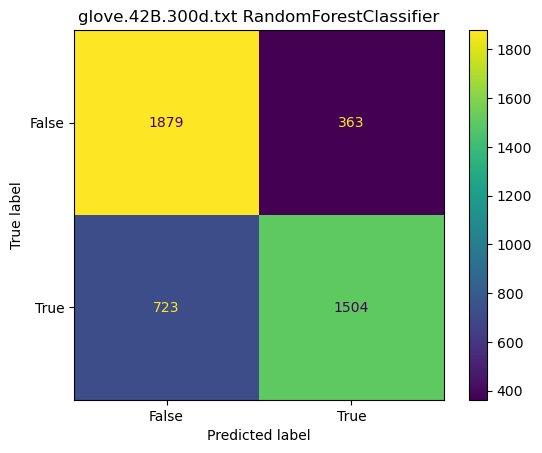

glove.42B.300d.txt SVC_Poly (0.7205191317968226, (array([1, 0, 1, ..., 0, 0, 1]), array([1, 0, 1, ..., 0, 0, 1])))
[('precision:', 0.7669213973799127), ('recall:', 0.6308935788055681), ('accuracy:', 0.7205191317968226), ('f1_score:', 0.6922887410692289)]
(0.7669213973799127, 0.6308935788055681, 0.7205191317968226, 0.6922887410692289)


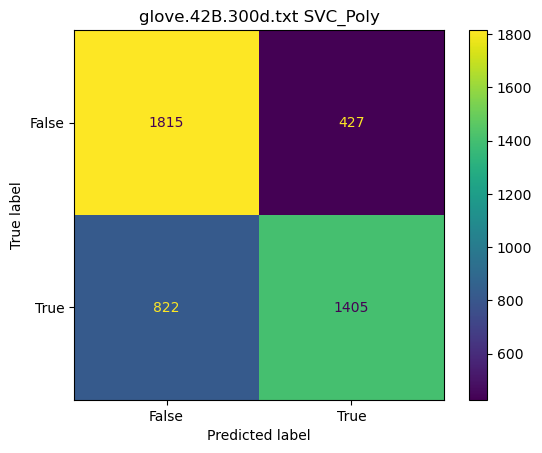

glove.42B.300d.txt SVC (0.8044305213694338, (array([1, 0, 1, ..., 0, 0, 1]), array([0, 1, 1, ..., 1, 0, 1])))
[('precision:', 0.8285575522098105), ('recall:', 0.7660529860799281), ('accuracy:', 0.8044305213694338), ('f1_score:', 0.7960802613159123)]
(0.8285575522098105, 0.7660529860799281, 0.8044305213694338, 0.7960802613159123)


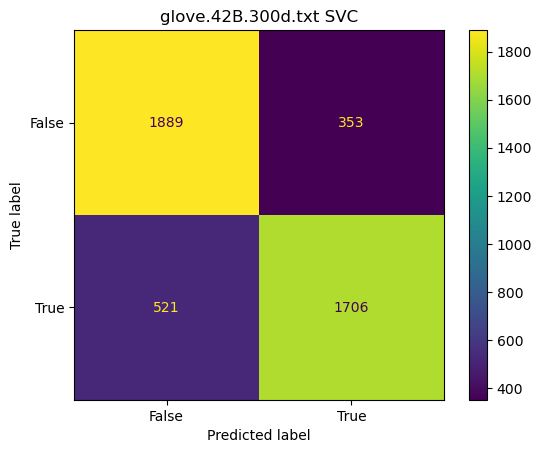

glove.6B.200d.txt RandomForestClassifier (0.7326023718952785, (array([0, 1, 0, ..., 1, 0, 1]), array([0, 1, 0, ..., 1, 0, 1])))
[('precision:', 0.7793633369923162), ('recall:', 0.6416629010393131), ('accuracy:', 0.7326023718952785), ('f1_score:', 0.7038413878562577)]
(0.7793633369923162, 0.6416629010393131, 0.7326023718952785, 0.7038413878562577)


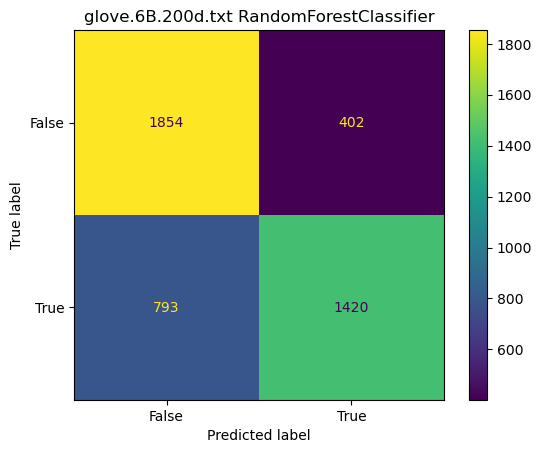

glove.6B.200d.txt SVC_Poly (0.6925486686059521, (array([0, 1, 0, ..., 1, 0, 1]), array([1, 1, 0, ..., 0, 0, 1])))
[('precision:', 0.709435846230654), ('recall:', 0.6421147763217352), ('accuracy:', 0.6925486686059521), ('f1_score:', 0.6740986717267552)]
(0.709435846230654, 0.6421147763217352, 0.6925486686059521, 0.6740986717267552)


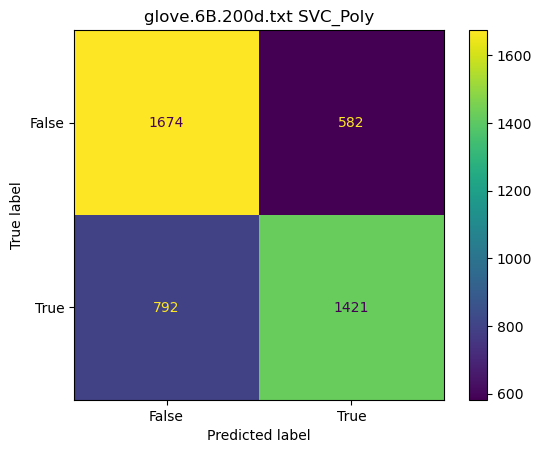

glove.6B.200d.txt SVC (0.7778026404117252, (array([0, 1, 0, ..., 1, 0, 1]), array([1, 1, 0, ..., 1, 0, 1])))
[('precision:', 0.7932692307692307), ('recall:', 0.745594215996385), ('accuracy:', 0.7778026404117252), ('f1_score:', 0.7686932215234102)]
(0.7932692307692307, 0.745594215996385, 0.7778026404117252, 0.7686932215234102)


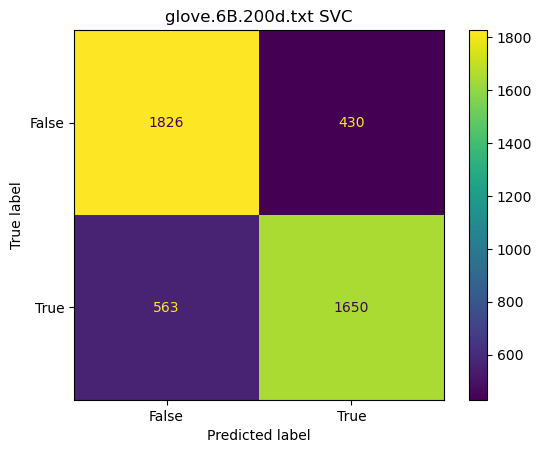

glove.6B.300d.txt RandomForestClassifier (0.7279033340792124, (array([1, 1, 0, ..., 0, 0, 0]), array([1, 0, 0, ..., 0, 0, 1])))
[('precision:', 0.7572815533980582), ('recall:', 0.6470046082949309), ('accuracy:', 0.7279033340792124), ('f1_score:', 0.6978131212723658)]
(0.7572815533980582, 0.6470046082949309, 0.7279033340792124, 0.6978131212723658)


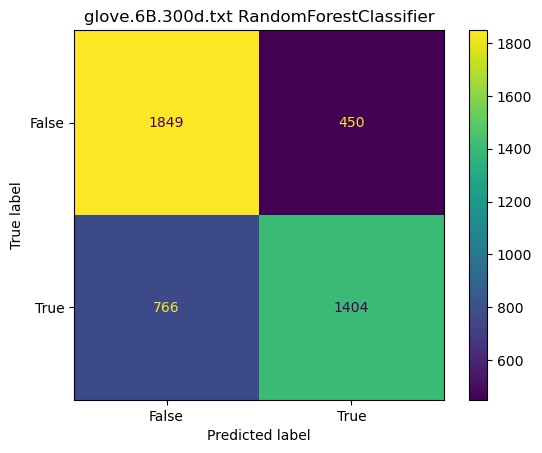

glove.6B.300d.txt SVC_Poly (0.7176102036249721, (array([1, 1, 0, ..., 0, 0, 0]), array([1, 1, 0, ..., 0, 0, 0])))
[('precision:', 0.7404661016949152), ('recall:', 0.6442396313364055), ('accuracy:', 0.7176102036249721), ('f1_score:', 0.689009364218827)]
(0.7404661016949152, 0.6442396313364055, 0.7176102036249721, 0.689009364218827)


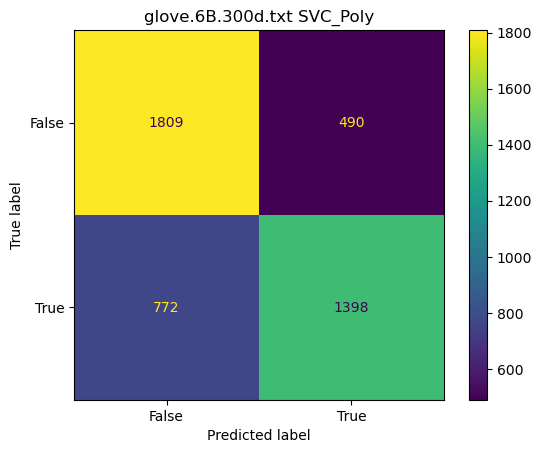

glove.6B.300d.txt SVC (0.7816066234056835, (array([1, 1, 0, ..., 0, 0, 0]), array([1, 1, 0, ..., 0, 0, 0])))
[('precision:', 0.8052147239263804), ('recall:', 0.7258064516129032), ('accuracy:', 0.7816066234056835), ('f1_score:', 0.763451284537082)]
(0.8052147239263804, 0.7258064516129032, 0.7816066234056835, 0.763451284537082)


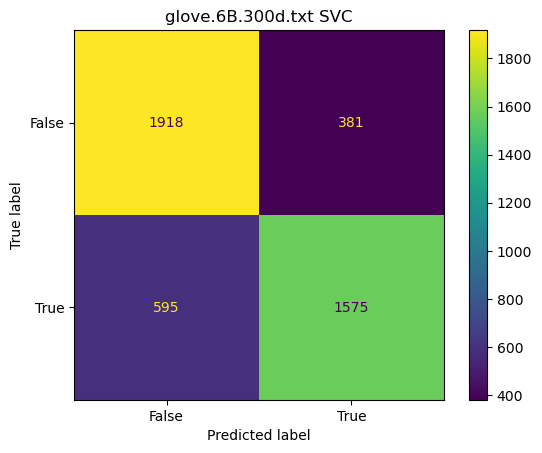

glove.840B.300d.txt RandomForestClassifier (0.7686283284851197, (array([1, 1, 1, ..., 1, 1, 0]), array([0, 0, 1, ..., 1, 1, 0])))
[('precision:', 0.8292547274749722), ('recall:', 0.6722272317403066), ('accuracy:', 0.7686283284851197), ('f1_score:', 0.7425298804780877)]
(0.8292547274749722, 0.6722272317403066, 0.7686283284851197, 0.7425298804780877)


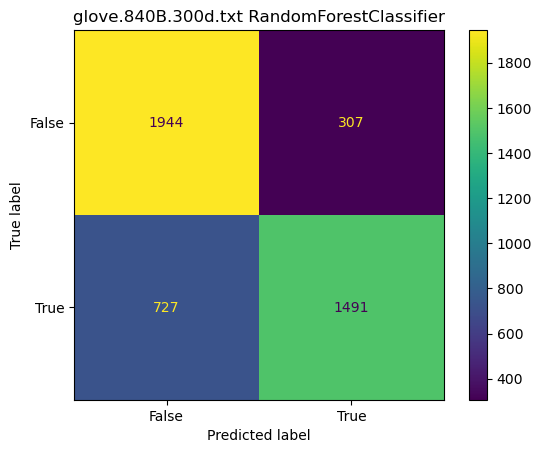

glove.840B.300d.txt SVC_Poly (0.7091071828149474, (array([1, 1, 1, ..., 1, 1, 0]), array([1, 0, 1, ..., 1, 1, 0])))
[('precision:', 0.766860465116279), ('recall:', 0.5946798917944094), ('accuracy:', 0.7091071828149474), ('f1_score:', 0.6698831894362621)]
(0.766860465116279, 0.5946798917944094, 0.7091071828149474, 0.6698831894362621)


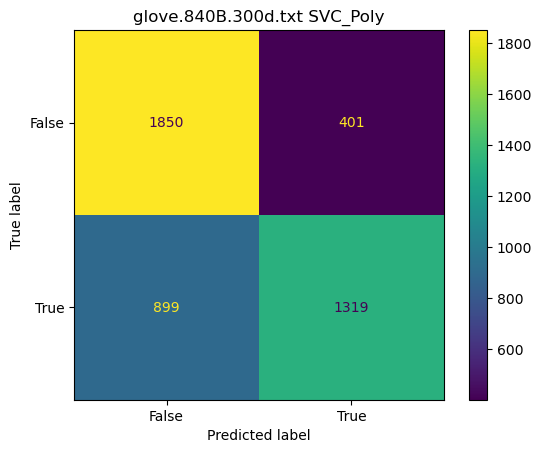

glove.840B.300d.txt SVC (0.8122622510628776, (array([1, 1, 1, ..., 1, 1, 0]), array([0, 0, 1, ..., 1, 1, 0])))
[('precision:', 0.8480565371024735), ('recall:', 0.757439134355275), ('accuracy:', 0.8122622510628776), ('f1_score:', 0.8001905215527507)]
(0.8480565371024735, 0.757439134355275, 0.8122622510628776, 0.8001905215527507)


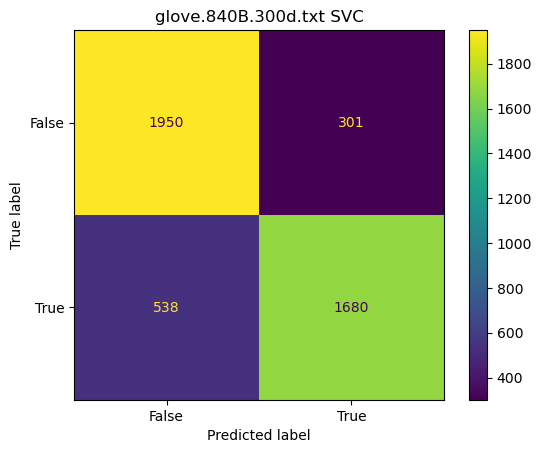

fasttext.txt RandomForestClassifier (0.7509509957484896, (array([0, 0, 0, ..., 0, 1, 1]), array([0, 1, 1, ..., 0, 0, 1])))
[('precision:', 0.7923728813559322), ('recall:', 0.674785746504285), ('accuracy:', 0.7509509957484896), ('f1_score:', 0.7288672350791718)]
(0.7923728813559322, 0.674785746504285, 0.7509509957484896, 0.7288672350791718)


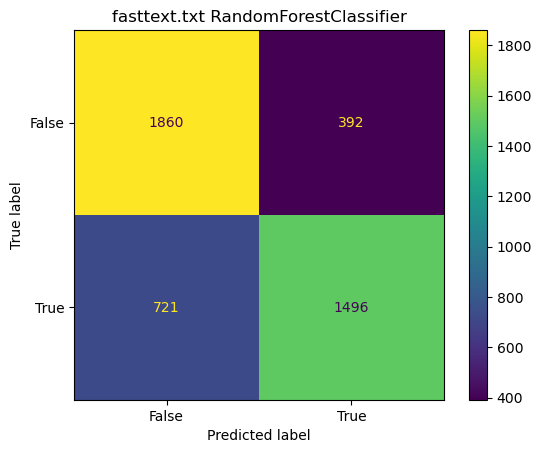

fasttext.txt SVC_Poly (0.5820093980756321, (array([0, 0, 0, ..., 0, 1, 1]), array([0, 1, 1, ..., 1, 1, 1])))
[('precision:', 0.5471494190759254), ('recall:', 0.9133964817320703), ('accuracy:', 0.5820093980756321), ('f1_score:', 0.6843528218992903)]
(0.5471494190759254, 0.9133964817320703, 0.5820093980756321, 0.6843528218992903)


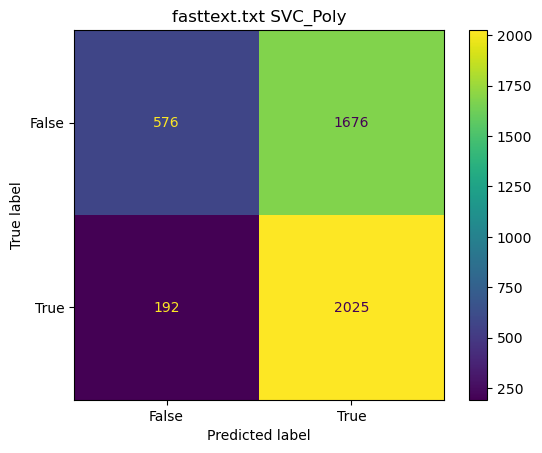

fasttext.txt SVC (0.7554262698590288, (array([0, 0, 0, ..., 0, 1, 1]), array([0, 1, 1, ..., 0, 0, 1])))
[('precision:', 0.740582191780822), ('recall:', 0.7803337843933243), ('accuracy:', 0.7554262698590288), ('f1_score:', 0.7599385020865365)]
(0.740582191780822, 0.7803337843933243, 0.7554262698590288, 0.7599385020865365)


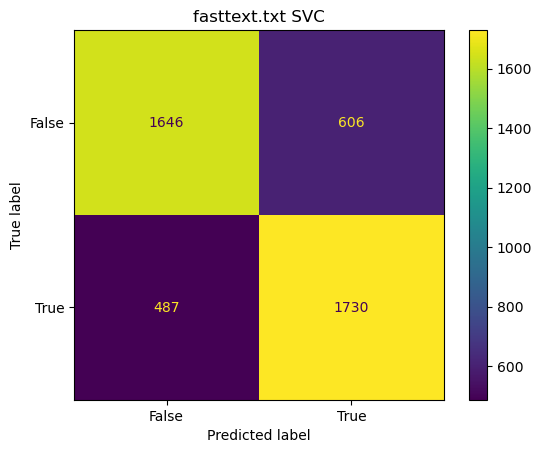

In [104]:
for model in all_results:
    for itm in all_results[model]:
        print(model, itm, all_results[model][itm])
        print(precision_recall_accuracy_f1(*all_results[model][itm][1]))
        plot_confusion_matrix(f"{model} {itm}", *all_results[model][itm][1])
        # all_results[model][itm] = [all_results[model][itm][0], list([list(all_results[model][itm][1][0]), list(all_results[model][itm][1][1])])]

In [41]:
all_results['fasttext.txt']

{'RandomForestClassifier': (0.7509509957484896,
  (array([0, 0, 0, ..., 0, 1, 1]), array([0, 1, 1, ..., 0, 0, 1]))),
 'SVC_Poly': (0.5820093980756321,
  (array([0, 0, 0, ..., 0, 1, 1]), array([0, 1, 1, ..., 1, 1, 1]))),
 'SVC': (0.7554262698590288,
  (array([0, 0, 0, ..., 0, 1, 1]), array([0, 1, 1, ..., 0, 0, 1])))}

In [45]:
final_models = [[file, model, all_results[file][model][0]] for file in all_results for model in all_results[file] if all_results[file][model][0] > 0.78]
final_models

[['glove.42B.300d.txt', 'SVC', 0.8044305213694338],
 ['glove.6B.300d.txt', 'SVC', 0.7816066234056835],
 ['glove.840B.300d.txt', 'SVC', 0.8122622510628776]]

In [48]:
import pickle
pickle
savedir = 'oxymoron/save_models'

In [49]:
for file in all_models:
    for model in all_models[file]:
        savename = f'{file}_{model}.pickle'
        pickle.dump(all_models[file][model], open(os.path.join(savedir, savename), "wb"))

In [50]:
saved_models = {model: pickle.load(open(os.path.join(savedir, model), "rb")) for model in os.listdir(savedir)}

In [51]:
print("Available Model Files:")
for file in os.listdir('oxymoron/save_models'):
    print(file)

Available Model Files:
fasttext_RandomForestClassifier.pickle
fasttext_SVC.pickle
fasttext_SVC_Poly.pickle
glove.42B.300d.txt_RandomForestClassifier.pickle
glove.42B.300d.txt_SVC.pickle
glove.42B.300d.txt_SVC_Poly.pickle
glove.6B.200d.txt_RandomForestClassifier.pickle
glove.6B.200d.txt_SVC.pickle
glove.6B.200d.txt_SVC_Poly.pickle
glove.6B.300d.txt_RandomForestClassifier.pickle
glove.6B.300d.txt_SVC.pickle
glove.6B.300d.txt_SVC_Poly.pickle
glove.840B.300d.txt_RandomForestClassifier.pickle
glove.840B.300d.txt_SVC.pickle
glove.840B.300d.txt_SVC_Poly.pickle


In [75]:
def predict(inputs, model = "glove.42B.300d.txt_SVC.pickle"):
    # changing model loads different files
    # ensemble is not done as loading different models at same time may crash the kernel because of memory
    if 'fasttext' in model:
        myglove = handle_fasttext()
    else:
        myglove = handle_glove(file = f'word_embeddings/{model.split("_")[0]}')
    model = pickle.load(open(os.path.join("oxymoron/save_models", model), "rb"))
    model_inputs = [myglove.difference_vector(wordset.split()[0], wordset.split()[1]) for wordset in inputs]
    predictions = model.predict(model_inputs)
    return [inputs[num] for num in range(len(predictions)) if predictions[num]]


In [95]:
inps = ['rough easy',
 'potential actual',
 'underdog favorite',
 'valley hill',
 'reddish neutral',
 'discontinue keep',
 'bondage freedom',
 'triple single',
 'structured unstructured',
 'inaccuracy truth',
 'tower spire',
 'barrel bbl',
 'coarse blunt',
 'opportunity time',
 'carriage coach',
 'awe reverence',
 'moderate temperate',
 'systematic taxonomic',
 'sit situate',
 'close complete',
 'tenacious long' 
]

In [96]:
predict(inps, model = 'fasttext_SVC.pickle')

['rough easy',
 'potential actual',
 'underdog favorite',
 'valley hill',
 'reddish neutral',
 'discontinue keep',
 'bondage freedom',
 'triple single',
 'structured unstructured',
 'inaccuracy truth',
 'sit situate']